In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     |████████████████████████████████| 106 kB 5.5 MB/s 
     |████████████████████████████████| 12.0 MB 4.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Тут придется авторизировать запрос к гугл драйву, извините.

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [4]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [5]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'refreshing', 'wonderfully', 'funniest', 'surprisingly', 'rare' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 67.22%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [6]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [7]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

(?u) -включает Юникод
\b -граница слов
\w - слова
\b\w - первые буквы слов, начало
\w+\b - полное слово

без пунктуации

Запустим его на реальных данных:

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Посмотрим на слова, попавшие в словарь:

In [10]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

Попробуем кого-нибудь таки сконвертировать

In [11]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [13]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
             

In [14]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.50%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [15]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight?,Feature
+1.855,refreshing
+1.760,wonderfully
+1.689,funniest
+1.647,surprisingly
+1.626,rare
+1.432,superb
+1.401,excellent
+1.365,incredible
+1.351,perfect
+1.302,delightful


Посмотрим на конкретные примеры его работы:

In [16]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [17]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [18]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy = 87.86%


In [22]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [23]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [24]:
import pickle

def lemm_data_docs(df_def):
  
  docs = [doc for doc in nlp.pipe(df_def.review.values)]

  list_lem_docs = []
  for doc in docs:
    list_lem_doc = []
    for token in doc:
      list_lem_doc.append(token.lemma_)
    list_lem_docs.append(list_lem_doc)

  df_def['review_lem'] = list_lem_docs
  df_def.head(5)

  return df_def

In [25]:
#for token in docs[0]:
#    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

In [26]:
train_df_lem = lemm_data_docs(train_df)

Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [27]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)
    
with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [28]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


In [29]:
def stemmer_word_in_list(list_docs):
  list_docs_stemm = []
  for doc in list_docs:
    list_doc_stemm = []
    for text_ in doc:
      list_word_stemm = []
      for word_tupl in text_:
        word_tupl_l = list(word_tupl)
        word_tupl_l[1] = stemmer.stem(word_tupl_l[1])
        list_word_stemm.append(word_tupl_l)
      list_doc_stemm.append(list_word_stemm)
    list_docs_stemm.append(list_doc_stemm)

  return list_docs_stemm

In [30]:
#train_docs = stemmer_word_in_list(train_docs)

In [31]:
train_docs[0][0]

[('Dreamgirls', 'dreamgirl'),
 (',', ','),
 ('despite', 'despite'),
 ('its', '-PRON-'),
 ('fistful', 'fistful'),
 ('of', 'of'),
 ('Tony', 'tony'),
 ('wins', 'win'),
 ('in', 'in'),
 ('an', 'an'),
 ('incredibly', 'incredibly'),
 ('weak', 'weak'),
 ('year', 'year'),
 ('on', 'on'),
 ('Broadway', 'broadway'),
 (',', ','),
 ('has', 'have'),
 ('never', 'never'),
 ('been', 'be'),
 ('what', 'what'),
 ('one', 'one'),
 ('would', 'would'),
 ('call', 'call'),
 ('a', 'a'),
 ('jewel', 'jewel'),
 ('in', 'in'),
 ('the', 'the'),
 ('crown', 'crown'),
 ('of', 'of'),
 ('stage', 'stage'),
 ('musicals', 'musical'),
 ('.', '.'),
 ('However', 'however'),
 (',', ','),
 ('that', 'that'),
 ('is', 'be'),
 ('not', 'not'),
 ('to', 'to'),
 ('say', 'say'),
 ('that', 'that'),
 ('in', 'in'),
 ('the', 'the'),
 ('right', 'right'),
 ('cinematic', 'cinematic'),
 ('hands', 'hand'),
 ('it', '-PRON-'),
 ('could', 'could'),
 ('not', 'not'),
 ('be', 'be'),
 ('fleshed', 'flesh'),
 ('out', 'out'),
 ('and', 'and'),
 ('polished', 'p

In [32]:
#test_docs = stemmer_word_in_list(test_docs)

**Задание** Попробуйте вместо лемм классифицировать основы.

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [33]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [34]:
def del_non_essences(df_def, stop_list):
    
  docs = [doc for doc in nlp.pipe(df_def.review.values)]

  list_lem_docs = []
  for doc in docs:
    list_lem_doc = []
    for token in doc:
      if token.ent_type_ is not stop_list and token.lemma_ != '-PRON-':
        list_lem_doc.append(token.lemma_)
    list_lem_docs.append(' '.join(list_lem_doc))

  df_def['review'] = list_lem_docs

  return df_def   

In [35]:
stop_list = ['PERSON','ORG','ORDINAL','FAC']

In [36]:
train_df = del_non_essences(train_df, stop_list)

In [37]:
train_df.head(5)

,is_positive,review,review_lem
0,0,"Dreamgirls , despite fistful of Tony win in an...","[Dreamgirls, ,, despite, -PRON-, fistful, of, ..."
1,0,this show come up with interesting location as...,"[this, show, come, up, with, interesting, loca..."
2,1,simply love this movie . also love the Ramones...,"[-PRON-, simply, love, this, movie, ., -PRON-,..."
3,0,spoiler ahead if want to call that ... would...,"[spoiler, ahead, if, -PRON-, want, to, call, -..."
4,1,all - time favorite movie ! have see many movi...,"[-PRON-, all, -, time, favorite, movie, !, -PR..."


In [38]:
test_df = del_non_essences(test_df, stop_list)

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [39]:
train_df['review']

0        Dreamgirls , despite fistful of Tony win in an...
1        this show come up with interesting location as...
2        simply love this movie . also love the Ramones...
3        spoiler ahead if want to call that ...   would...
4        all - time favorite movie ! have see many movi...
                               ...                        
24995    be a big fan of the movie , but not for the us...
24996    be not go to bother with a plot synopsis since...
24997    this movie . . . do not know . why would take ...
24998    see this film on dvd yesterday and be gob - sm...
24999    this be a disappointment - none of the nuance ...
Name: review, Length: 25000, dtype: object

<a list of 225 Patch objects>

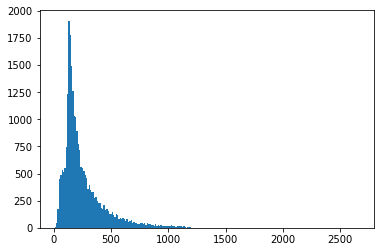

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [41]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 16777


**Задание** Сконвертируйте данные

In [42]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [43]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [44]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [45]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1073728   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,074,499
Trainable params: 1,074,499
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=15, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/15
196/196 [==============================] - 4s 18ms/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 0.5346 - val_accuracy: 0.8627
Epoch 2/15
196/196 [==============================] - 3s 17ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.5545 - val_accuracy: 0.8634
Epoch 3/15
196/196 [==============================] - 3s 17ms/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.5763 - val_accuracy: 0.8619
Epoch 4/15
196/196 [==============================] - 3s 17ms/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.5962 - val_accuracy: 0.8612
Epoch 5/15
196/196 [==============================] - 3s 17ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.6107 - val_accuracy: 0.8610
Epoch 6/15
196/196 [==============================] - 3s 17ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.6252 - val_accuracy: 0.8608
Epoch 7/15
196/196 [==============================] - 3s 16ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.6468 - val_accuracy: 0.8604

**Задание** Подсчитайте качество модели на тесте

In [51]:
pred = model.predict(X_test)

In [68]:
iz = 0
for i in range(len(test_df.is_positive)):
  if test_df.is_positive[i] == int(round(pred[i][0])):
    iz += 1

iz/len(test_df.is_positive)

0.85908

Проверка показала высокий val_accuracy, при увеличении эпох можно еще поднять данное значение